In [1]:
from squlearn.feature_map import *
from qiskit.quantum_info import entropy, Statevector, DensityMatrix
import numpy as np
from qiskit import QuantumCircuit
from qiskit import execute
from qiskit.quantum_info import partial_trace
from qiskit import Aer, transpile
from sklearn.decomposition import PCA



#from squlearn.exponential_concentration_tools import *
#from squlearn.exponential_concentration_tools.datasets import *
#from squlearn.exponential_concentration_tools.data_processing import *
#from squlearn.exponential_concentration_tools.simulations import *

from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from squlearn.util import Executor

#import tensorflow as tf
#import tensorflow_datasets as tfds

import sys

from itertools import combinations




In [2]:
from squlearn.feature_map import HardwareEfficientEmbeddingMap # hardware efficient embedding map must be implemented in squlearn, if not comment out
from squlearn.feature_map import QiskitFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from squlearn.kernel.matrix import FidelityKernel, ProjectedQuantumKernel
from squlearn.kernel.ml import QSVR, QKRR
from squlearn.util import Executor
from qiskit.primitives import Estimator, Sampler


from sklearn.preprocessing import MinMaxScaler # For scaling the data to [0, 1] if not kernels fail

from qiskit.quantum_info import Statevector, partial_trace
from squlearn.feature_map import *
from itertools import combinations
from squlearn.expectation_operator import CustomExpectationOperator



Related to DRM PQK implementation

In [3]:


# For n-drm implementations: 

def interpret_measurement_str(input_string):
    """
    # Test examples
    print(interpret_string("Z1DRM"))     # Output: ("Z", 1)
    print(interpret_string("XYZ3DRM"))   # Output: ("XYZ", 3)
    """
    # Initialize measurement_basis and nDRM variables
    measurement_basis = ""
    nDRM = ""

    # Find the index where the numeric part of the string starts
    numeric_index = None
    for i in range(len(input_string)):
        if input_string[i].isdigit():
            numeric_index = i
            if input_string[i+1].isdigit():
                return input_string[:numeric_index], int(input_string[numeric_index:numeric_index+2])
            break

    # If no numeric part found, return empty values for measurement_basis and nDRM
    if numeric_index is None:
        return measurement_basis, nDRM

    # Extract the measurement_basis and nDRM from the input_string
    measurement_basis = input_string[:numeric_index]
    nDRM = input_string[numeric_index]

    return measurement_basis, int(nDRM)

def generate_combinations(string_len, n_elements, symbol):
    """
    Generates all possible combinations of a given number of elements in a string of a given length.
    example: 
    generate_combinations(3, 2, "X") -> ["XXI", "IXX", "XIX"]
    """
    # If the number of elements requested is greater than the string length,
    # it's not possible to form such combinations, so return an empty list.
    if n_elements > string_len:
        return []

    # Generate all possible combinations of indices where the symbol ("X")
    # should be placed in the string.
    combinations_list = list(combinations(range(string_len), n_elements))

    # Initialize the list to store all the combinations.
    result = []
    
    # Iterate through each combination of indices and create the corresponding string.
    for combo in combinations_list:
        # Initialize a list with "I" (identity) characters for the string.
        string_characters = ["I"] * string_len
        
        # Set the symbol ("X") at the appropriate positions based on the combination.
        for idx in combo:
            string_characters[idx] = symbol
        
        # Convert the list of characters into a single string and add it to the result list.
        result.append("".join(string_characters))
    
    # Return the list of all unique combinations.
    return result


def generate_n_density_reduced_matrices(num_qubits, nDRM, basis  ):
    """
    Generates all possible density matrices for a given number of qubits and returns them as a list of CustomExpectationOperators
    """
    X_measurements = generate_combinations(num_qubits, nDRM, "X")
    Y_measurements = generate_combinations(num_qubits, nDRM, "Y")
    Z_measurements = generate_combinations(num_qubits, nDRM, "Z")
    if basis == "XYZ":
        measurements = X_measurements + Y_measurements + Z_measurements
    elif basis == "XY":
        measurements = X_measurements + Y_measurements
    elif basis == "XZ":
        measurements = X_measurements + Z_measurements
    elif basis == "YZ":
        measurements = Y_measurements + Z_measurements
    elif basis == "Z":
        measurements = Z_measurements
    elif basis == "X": 
        measurements = X_measurements
        
    for i in range(len(measurements)):
        measurements[i] = CustomExpectationOperator(num_qubits, measurements[i])
    return measurements


Related to ZZEmbedding

In [4]:
def self_product_without_pi(x: np.ndarray) -> float:
    """
    Define a function map from R^n to R.

    Args:
        x: data

    Returns:
        float: the mapped value
    """
    if len(x) == 1:
        coeff =  x[0]
    elif len(x) == 2:
        coeff = x[0]*x[1]
    else: 
        raise ValueError("The length of x should be 1 or 2!")
    return coeff


Related to datasets:

In [5]:
#Useful for datasets 
MNIST = fetch_openml('mnist_784')

def pca_sklearn(X, n_components):
    """
    Performs PCA on the input dataset X and returns the projected dataset X_pca as implemented in sklearn"""
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca


def hypercube_classifier(vector, half_width = np.pi):
    n = len(vector)
    width = 2 * half_width / 2**(1/n)
    for coordinate in vector:
        if coordinate < -width/2 or coordinate > width/2:
            return -1 
    return 1

def get_hypercube_dataset(num_qubits, num_samples=100, half_width=np.pi, random_seed=None):
    """
    Generates a dataset of num_samples points sampled uniformly from the hypercube [-1, 1]^num_qubits.
    If random_seed is not None, it will set the random seed for reproducibility.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    X = np.random.uniform(-half_width, half_width, (num_samples, num_qubits))
    y = np.array([hypercube_classifier(vector, half_width) for vector in X])
    return X, y

def get_MNIST_pca_filtered_dataset(n, num_samples=40, pca=pca_sklearn, mnist=None, random_seed=1):
    """
    Gets the MNIST dataset, performs PCA on it, and filters for only 0 and 1.
    Returning the projected dataset X_pca and the corresponding labels y.
    If random_seed is not None, it will set the random seed for reproducibility.
    """
    np.random.seed(random_seed)

    # Load MNIST dataset
    if mnist is None:
        mnist = fetch_openml('mnist_784')
        print("fetching mnist")

    X = mnist.data
    y = mnist.target

    X_pca = pca(X, n)

    # Filter the dataset to include only "0" and "1" digits
    binary_digits = ['0', '1']
    binary_indices = np.isin(y, binary_digits)
    X_pca_binary = X_pca[binary_indices]
    y_binary = y[binary_indices]

    # Generate random indices
    indices = np.random.choice(len(y_binary), size=num_samples, replace=False)
    # Select elements using the random indices for both arrays
    y_binary_f = y_binary.reset_index(drop=True)[indices]
    y_binary_f = y_binary_f.to_numpy().astype(float)

    X_pca_binary = X_pca_binary[indices]

    return X_pca_binary, y_binary_f



C:\Users\jsl-rf\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Main function

In [6]:
# Define the executor and set the desired number of shots
#executor = Executor('qasm_simulator')


# Fidelity
samples  = Executor(Sampler())
samples.set_shots(None)


#Projected
executor = Executor(Estimator())
executor.set_shots(None)


results = []  # List to store the results

def run_calculation(fmap, num_qubits, num_layers, rotation_gate, KernelMethod, directory, dataset_name, dataset_preprocessing,
                     extra_parameters = None, extra_name = None, measurement_str = None, outer_kernel = None, outer_kernel_parameter = None):
    
    random_seed=1 # For reproducibility

    num_samples = 40
    # Define the feature map
    if fmap == "ZZEmbedding":
        fmap = QiskitFeatureMap(ZZFeatureMap, feature_dimension=num_qubits, reps = num_layers, data_map_func = self_product_without_pi )
    elif fmap == "HEE":
        # For this to work: class HardwareEfficientEmbeddingMap(FeatureMapBase) must be in feature_map_implemented.py
        fmap = HardwareEfficientEmbeddingMap(num_qubits, num_qubits, num_layers, rotation_gate)
          
    
    # Define the kernel
    if KernelMethod == ProjectedQuantumKernel:
        measurement_basis, nDRM = interpret_measurement_str(measurement_str)
        measurements = generate_n_density_reduced_matrices(num_qubits, nDRM, basis=measurement_basis)

        kernel = KernelMethod(fmap,executor=executor, measurement = measurements, outer_kernel = outer_kernel, gamma = outer_kernel_parameter ) #measurement = XYZ, outerkernel = Gaussian ### ADD THIS TO DATA PROCESSING
        kernel.assign_parameters([])
    elif KernelMethod == FidelityKernel:
        kernel = KernelMethod(fmap,executor=samples)
        
    # Get the dataset
    if dataset_name == "MNIST":    
        # Generate some training data
        X_train, y_train = get_MNIST_pca_filtered_dataset(num_qubits, num_samples = num_samples, pca=pca_sklearn, mnist = MNIST, random_seed = random_seed)
    elif dataset_name == "Hypercube":
        X_train, y_train = get_hypercube_dataset(num_qubits, num_samples = num_samples, half_width = np.pi, random_seed = random_seed)
    #elif dataset_name == "fMNIST":
    #    X_train, y_train, x_test, y_test = get_fMNIST_dataset(num_qubits, num_samples, fMNIST)
    #elif dataset_name == "kMNIST":
    #    X_train, y_train, x_test, y_test = get_KMNIST_pca_filtered_dataset(num_qubits, num_samples, kmnist=kMNIST)
    #elif dataset_name == "plasticc":
    #    X_train, x_test, y_train, y_test = get_plasticc_PCA_dataset(num_qubits, num_samples, plasticc)
    
        
    # Preprocess the dataset
    if dataset_preprocessing == "NoPreprocessing":
        pass
    elif dataset_preprocessing == "MinMax":
        Scaler = MinMaxScaler(extra_parameters)
        Scaler.fit(X_train)
        X_train = Scaler.transform(X_train)

    dataset = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)

    # Calculate the entanglement score
    #entanglement_score = meyer_wallach_given_features(fmap, num_qubits, X_train, save_evolution=True)

    # Calculate the kernel matrix
    #entanglement_score = np.zeros(num_samples)
    entanglement_score = None
    
    #Calculate the kernel matrix
    K  = kernel.evaluate(X_train)


    # Save the results
    feature_map = f"ZZEmbedding" 
    parameters = None

    if KernelMethod == ProjectedQuantumKernel:
        extra_name = "ProjectedKernel"
    elif KernelMethod == FidelityKernel:
        extra_name = "FidelityKernel"


    result = parameters_dict = {
        "feature_map": feature_map,
        "num_layers": num_layers,
        "num_qubits": num_qubits,
        "parameters": parameters,
        "dataset_name": dataset_name,
        "dataset_preprocessing": dataset_preprocessing,
        "extra_parameters": extra_parameters,
        "extra_name": extra_name,
        "dataset": np.array(dataset),
        "kernel": np.array(K),
        "entanglement_score": np.array(entanglement_score),
        "measurement_basis": measurement_basis,
        "outerkernel": outer_kernel,
        "outerkernel_parameter": outer_kernel_parameter
        #"test_dataset": np.array(test_dataset),
        #"test_kernel": np.array(test_kernel),
        #"test_prediction": np.array(test_prediction)
    }
    return result
    
    #SaveParameterDatasetAndKernel(directory, feature_map, num_layers, num_qubits, parameters, dataset_name, dataset, K, dataset_preprocessing, extra_parameters, 
                                  #extra_name, entanglement_score, measurement_str, outer_kernel, outer_kernel_parameter)


Testing

In [7]:
num_qubits = 3
num_layers = 10
rotation_gate = None
KernelMethod = ProjectedQuantumKernel
directory = None #Saving not implemented
dataset_name = "Hypercube"
dataset_preprocessing = "NoPreprocessing"
extra_parameters = None
extra_name = None
measurement_str = "XYZ2DRM"
outer_kernel = "Gaussian"
outer_kernel_parameter = 1


result = run_calculation("ZZEmbedding", num_qubits, num_layers, rotation_gate, KernelMethod, directory, dataset_name, dataset_preprocessing,
                     extra_parameters, extra_name, measurement_str, outer_kernel, outer_kernel_parameter)

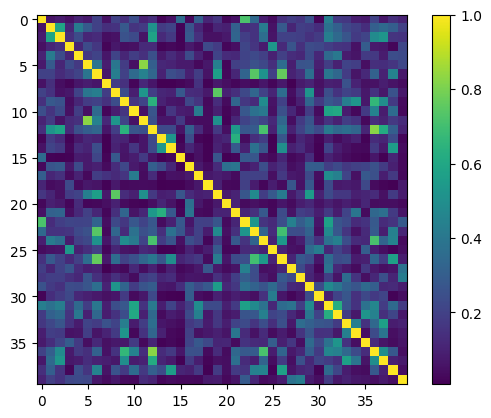

In [8]:
# plot heatmap of kernel matrix
plt.imshow(result['kernel'], interpolation='nearest')
#show colorbar
plt.colorbar()


About kernel concentration:

In [9]:
def variance_off_diagonal(M):
    """
    Remove main diagonal of M, transform M to a 1D array and calculates the variance of this array.
    """
    #removes main diagonal:
    M = M[~np.eye(M.shape[0],dtype=bool)].reshape(M.shape[0],-1)
    M = M.flatten()
    variance = np.var(M)
    return variance

In [10]:
variance_off_diagonal(result['kernel']) #Kernel concentration

0.022100828092884935

Text(0, 0.5, 'Variance of kernel matrix')

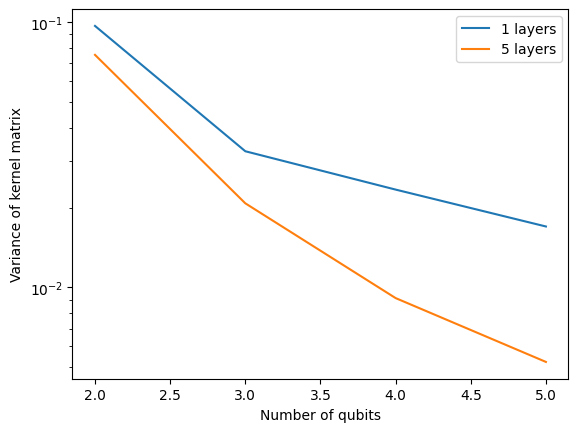

In [11]:
num_qubits_list = [2, 3, 4, 5] # 5, 6, 8, 10]
num_layers_list = [1, 5] #, 8, 16, 25, 50]

for index_layer, layer in enumerate(num_layers_list):
    Kvariances = []
    for index_qubit, qubit in enumerate(num_qubits_list):
        result = run_calculation("ZZEmbedding", qubit, layer, rotation_gate, KernelMethod, directory, dataset_name, dataset_preprocessing,
                     extra_parameters, extra_name, measurement_str, outer_kernel, outer_kernel_parameter)
        Kvariances.append(variance_off_diagonal(result['kernel']))
    plt.plot(num_qubits_list, Kvariances, label = f"{layer} layers")

plt.legend()
#log scale
plt.yscale('log')
plt.xlabel("Number of qubits")
plt.ylabel("Variance of kernel matrix")